In [2]:
import os
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets

## Download Data

In [3]:
df = pd.read_csv('https://media.githubusercontent.com/media/Benz-Poobua/ESS-469-Project/main/bulk_event_magnitude_phase_nwf_FV.csv', parse_dates=['datetime', 'arrdatetime'])
df.index = df.arid
feature_df = df.copy().iloc[:, -140:]

In [4]:
df.shape

(65828, 182)

In [5]:
# Explicitly (re)define the bounding box used for the PNSN catalog query
latll, lonll = 42.0, -125.5
latur, lonur = 49.0, -122.0
t0, t1 = UTCDateTime(2015,1,1), UTCDateTime(2023,11,17)

In [6]:
df_event = df.copy()
# enforce bounds
df_event = df_event[
    (df_event.lat >= latll)
    & (df_event.lat <= latur)
    & (df_event.lon >= lonll)
    & (df_event.lon <= lonur)
]
display(df_event)

,Unnamed: 0,evid,magid,magnitude,magtype,uncertainty,nsta,nobs,orid,lat,...,f130,f131,f132,f133,f134,f135,f136,f137,f138,f139
arid,,,,,,,,,,,,,,,,,,,,,
12661338,12661338,60944277,2471028,0.82,l,0.296000,3,4,1988943,47.661333,...,14.484606,-52.683372,38.403280,-45.746790,50.819557,-45.633396,31.210033,-16.627733,13.026130,-21.439693
12662833,12662833,60944277,2471028,0.82,l,0.296000,3,4,1988943,47.661333,...,25.073507,-58.765530,37.206387,-58.972607,55.458520,-37.358746,13.465749,-34.312565,5.860689,-6.424910
12662838,12662838,60944277,2471028,0.82,l,0.296000,3,4,1988943,47.661333,...,-33.046986,-67.737350,-18.863752,3.267522,18.565746,-19.835562,-18.204021,-12.103196,7.311026,0.775492
12662848,12662848,60944277,2471028,0.82,l,0.296000,3,4,1988943,47.661333,...,-38.281887,-79.877690,-30.702717,10.123881,26.627289,-16.341555,-33.081036,-27.686909,-0.363812,6.866379
12662863,12662863,60944277,2471028,0.82,l,0.296000,3,4,1988943,47.661333,...,13.923862,-55.464027,45.498100,-63.175450,40.160362,-40.069866,5.723290,-12.340886,-0.627137,-8.258294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13556103,13556103,61158502,2491533,0.64,l,0.142000,13,17,2496943,46.258000,...,17.694115,-42.647053,36.557346,-60.849274,35.370728,-44.331520,18.878307,-36.363972,18.565542,-18.858948
14979208,14979208,61561482,3028508,0.56,l,0.184579,7,10,3110073,46.317167,...,8.296428,-48.338020,26.869736,-51.696370,26.769655,-28.356382,22.153025,-14.537891,15.924957,-7.478184
14979218,14979218,61561482,3028508,0.56,l,0.184579,7,10,3110073,46.317167,...,-0.053781,-47.938965,26.271673,-38.142647,39.733147,-23.460516,22.156475,-31.677578,5.292915,-14.468358


In [13]:
# Do an initial mapping of events using plotly.express
#px.scatter_geo(df_event,lat='lat',lon='lon',color='magnitude')

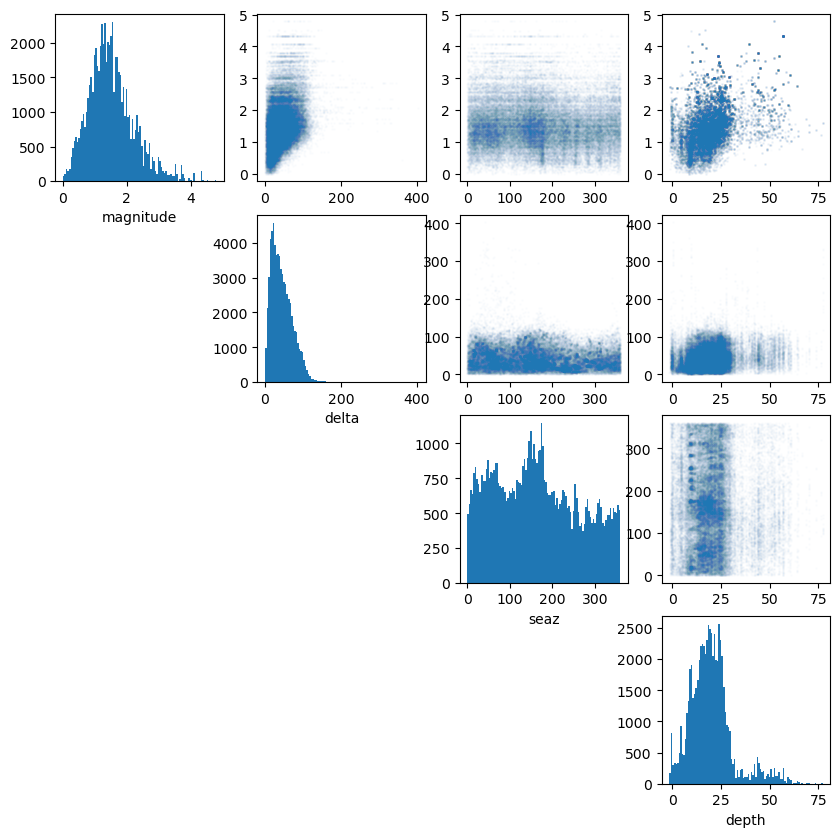

In [7]:
# The distribution of source parameters that E3WS predicts
fig = plt.figure(figsize=(10,10))
gs = fig.add_gridspec(ncols=4, nrows=4)
fields = ['magnitude','delta','seaz','depth']
for _i, _ifld in enumerate(fields):
    for _j, _jfld in enumerate(fields):
        if _i <= _j:
            ax = fig.add_subplot(gs[_i,_j])
            if _i == _j:
                ax.hist(df_event[_ifld].values, 100)
                ax.set_xlabel(_ifld)
            else:
                ax.scatter(df_event[_jfld], df_event[_ifld], s=1, alpha=0.01)

## Data Spiltting 

In [8]:
X = df_event.drop(['evid','magid','magnitude', 'magtype', 'uncertainty',
                   'nsta', 'nobs', 'orid', 'lat', 'lon', 'depth', 'datetime', 'erhor', 
                   'erlat', 'erlon', 'sdep','gap','quality','ndef','nbs','nbfm','fdepth',
                   'fepi','arrdatetime','arid','iphase','sta','net','seedchan','location',
                   'fm','qual','arrquality','snr','delta','seaz','in_wgt','timeres','rflag',
                   'nchan_wf','ntr_wf'], axis=1)  # Assuming 'magnitude' is the column name for the target variable
y = df_event['magnitude']

In [9]:
# Splitting the data into train (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
X1_train = X_train.iloc[:, -140:]
X2_test = X_test.iloc[:, -140:]